In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal, Quantile_Lorentzian as Q_Lorentzian

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK, Sol_Kuramoto_mf2 as mf2
from parfor import parfor
from scipy import interpolate

In [57]:
@numba.jit(nopython=True)
def RK4_short_theta(f, y0, t, args=(),sum_range = 2010):
    save_time = sum_range
    integtime = len(t) - save_time
    h = t[1] - t[0]
    if h <= 0.01:
        n_save = sum_range*10
    else:
        n_save = sum_range
    N = len(y0)//2
    y = np.zeros((n_save, N))
    y_ = y0
    for i in range(integtime):
        k1 = f(y_, t, *args)
        k2 = f(y_ + k1 * h / 2.0, t + h / 2.0, *args)
        k3 = f(y_ + k2 * h / 2.0, t + h / 2.0, *args)
        k4 = f(y_ + k3 * h, t + h, *args)
        y_ = y_ + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    num = 0
    if h <= 0.01:
        for i in range(n_save):
            k1= f(y_, t[i], *args)
            k2= f(y_ + k1 * h / 2.0, t[i] + h / 2.0, *args)
            k3= f(y_ + k2 * h / 2.0, t[i] + h / 2.0, *args)
            k4= f(y_ + k3 * h, t[i] + h, *args)
            y_ =y_ + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
            if i%10 == 0:
                y[num] = y_[:N]
                num+= 1
    else:
        for i in range(n_save):
            k1= f(y_, t[i], *args)
            k2= f(y_ + k1 * h / 2.0, t[i] + h / 2.0, *args)
            k3= f(y_ + k2 * h / 2.0, t[i] + h / 2.0, *args)
            k4= f(y_ + k3 * h, t[i] + h, *args)
            y_ =y_ + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
            y[i] = y_[:N]
    return y
@numba.jit(nopython=True)
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

@numba.jit(nopython=True)
def Kuramoto_mf(Theta,t,omega,N,m,K):
    if m == 0:
        Theta = Theta.copy()
        theta = Theta[:N]
        r,psi = get_order_parameter(theta,N)
        dtheta = omega + K*r*np.sin(psi - theta)
        Theta[:N] = dtheta
    else:
        Theta = Theta.copy()
        theta,dtheta = Theta[:N],Theta[N:2*N]
        r,psi = get_order_parameter(theta,N)
        ddtheta = (1/m)*(-dtheta + omega + K*r*np.sin(psi - theta))
        Theta[:N] = dtheta
        Theta[N:2*N] = ddtheta
    return Theta

In [86]:
import numba as nb
import numpy as np

# --- r, psi (복소수 없이) ---
@nb.njit(fastmath=True, cache=True)
def _order_param(theta):
    c = 0.0
    s = 0.0
    for i in range(theta.size):
        c += np.cos(theta[i])
        s += np.sin(theta[i])
    invN = 1.0 / theta.size
    c *= invN; s *= invN
    r = np.sqrt(c*c + s*s)
    psi = np.arctan2(s, c)
    return r, psi

# --- 커라모토 RHS: state와 같은 길이 반환 ---
@nb.njit(fastmath=True, cache=True)
def Kuramoto_mf_rhs(Theta, t_scalar, omega, N, m, K):
    # Theta: len N (m=0) 또는 len 2N (m>0)
    out = np.empty_like(Theta)
    if m == 0.0:
        theta = Theta[:N]
        r, psi = _order_param(theta)
        for i in range(N):
            out[i] = omega[i] + K * r * np.sin(psi - theta[i])
    else:
        theta = Theta[:N]
        dtheta = Theta[N:2*N]
        r, psi = _order_param(theta)
        invm = 1.0/m
        # θ' = dθ,  dθ' = ( -dθ + ω + K r sin(ψ-θ) ) / m
        for i in range(N):
            out[i] = dtheta[i]
        for i in range(N):
            out[N+i] = invm * (-dtheta[i] + omega[i] + K * r * np.sin(psi - theta[i]))
    return out

# --- RK4 + r 저장: 결과 shape = (n_save(eff), N+1) ---
@nb.njit(fastmath=True, cache=True)
def RK4_short_theta_store_r(y0, t, omega, N, m, K, sum_range=2010):
    save_time = sum_range
    integ_steps = t.size - save_time
    h = t[1] - t[0]

    # 저장 간격
    save_stride = 10 if h <= 0.01 else 1
    n_save_raw = save_time if h > 0.01 else save_time * 10
    n_save_eff = n_save_raw // save_stride

    # 출력: [r, theta...]
    out = np.empty((n_save_eff, N + 1), dtype=np.float64)

    # 상태 길이 확인
    state_len = y0.size
    twoN = 2 * N
    if m == 0.0 and state_len != N:
        # 1차인데 2N 형태로 들어왔으면 앞의 N만 사용
        y_ = y0[:N].copy()
    else:
        # 2차면 길이 2N 가정
        y_ = y0.copy()

    # 워밍업
    t0 = t[0]
    for k in range(integ_steps):
        tk = t0 + k*h
        k1 = Kuramoto_mf_rhs(y_, tk,      omega, N, m, K)
        k2 = Kuramoto_mf_rhs(y_ + 0.5*h*k1, tk+0.5*h, omega, N, m, K)
        k3 = Kuramoto_mf_rhs(y_ + 0.5*h*k2, tk+0.5*h, omega, N, m, K)
        k4 = Kuramoto_mf_rhs(y_ + h*k3,     tk+h,     omega, N, m, K)
        y_ = y_ + (h/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)
        # 필요 시 래핑 (속도↑ 위해 주기적으로만 해도 됨)
        # if (k & 31) == 0:
        #     _wrap_angles_inplace(y_, N, m)

    # 저장 루프
    idx = 0
    for i in range(n_save_raw):
        ti = t0 + (integ_steps + i)*h
        k1 = Kuramoto_mf_rhs(y_, ti,      omega, N, m, K)
        k2 = Kuramoto_mf_rhs(y_ + 0.5*h*k1, ti+0.5*h, omega, N, m, K)
        k3 = Kuramoto_mf_rhs(y_ + 0.5*h*k2, ti+0.5*h, omega, N, m, K)
        k4 = Kuramoto_mf_rhs(y_ + h*k3,     ti+h,     omega, N, m, K)
        y_ = y_ + (h/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)

        if (i % save_stride) == 0:
            # r 계산 후 [r, theta] 저장
            if m == 0.0:
                theta = y_
            else:
                theta = y_[:N]
            r, _ = _order_param(theta)
            out[idx, 0] = r
            for j in range(N):
                out[idx, 1 + j] = theta[j]
            idx += 1

    return out


In [88]:
seed =11
N = 5000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

In [89]:
m = 6
dt = 0.1
t = np.arange(0,10100,dt)
# K = 5.3
K = 7
Y = np.r_[theta_random,theta_random]

In [67]:
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [68]:
sum_range = 1000

In [ ]:
# 준비
# y0: m==0이면 길이 N, m>0이면 길이 2N
# t: 등간격 배열
# omega: 길이 N
# N, m, K 지정
T1 = RK4_short_theta_store_r(y0=Y, t=t, omega=omega, N=N, m=m, K=K, sum_range=1001)
# T.shape == (저장스텝수, N+1), 첫 컬럼은 r, 이후는 theta[0..N-1]


In [93]:
rs = T1[:,0]
theta = T1[:,1:]
avg_theta = (theta[1000] - theta[0])/(t[1000] - t[0])
v_t = avg_theta
expj = np.exp(1j*theta[-500:])

con0 = np.abs(v_t - v_t[N//2]) < 0.15
c_0, = np.where(con0)
c_p, = np.where(np.logical_and(~con0, omega > 0))
c_m, = np.where(np.logical_and(~con0, omega < 0))
r0 = np.mean(np.abs(np.sum(expj[:,c_0],axis=1)/N))
rp = np.mean(np.abs(np.sum(expj[:,c_p],axis=1)/N))
rm = np.mean(np.abs(np.sum(expj[:,c_m],axis=1)/N))
rpl = np.mean(np.abs(np.sum(expj[:,c_p0],axis=1)/N))
rml = np.mean(np.abs(np.sum(expj[:,c_m0],axis=1)/N))
rs = np.mean(rs[-500:])
N0,NP,NM = len(c_0),len(c_p0),len(c_m0)

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [94]:
theta

array([[-35322.41816282, -33435.60732235, -32265.89404049, ...,
         32248.81505441,  33402.88067354,  35300.76697524],
       [-35322.78024109, -33435.92127354, -32266.20514759, ...,
         32249.11679873,  33403.22392707,  35301.12146984],
       [-35323.14806886, -33436.23814036, -32266.51158998, ...,
         32249.42095318,  33403.55957606,  35301.46857812],
       ...,
       [-35674.74605884, -33768.8240474 , -32587.67403408, ...,
         32570.63002586,  33736.28787575,  35652.92892024],
       [-35675.12498802, -33769.13794247, -32587.97796663, ...,
         32570.95151568,  33736.6235212 ,  35653.2769602 ],
       [-35675.50542171, -33769.45860855, -32588.28916916, ...,
         32571.28237415,  33736.94979404,  35653.61621048]])

In [77]:
R = np.abs(np.mean(np.exp(1j*T1[:,1:]),axis=1))

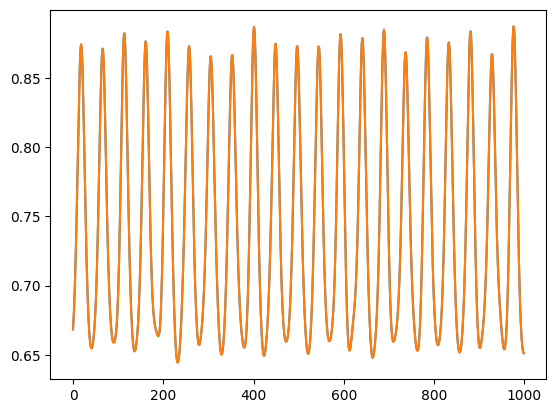

In [ ]:
plt.plot(T1[:,0])
plt.plot(R)
plt.plot(rs[-sum_range:])

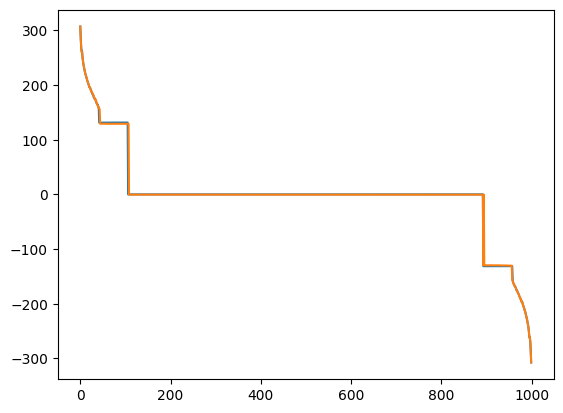

In [73]:
plt.plot(T1[-1000,1:] - T1[-1,1:])
plt.plot(T[-1000,:] - T[-1,:])

In [ ]:
mcs_rp0 = np.load('Simul/mcs_rp0.npz',allow_pickle=True)
mcs_rpdh = np.load('Simul/mcs_rpdh.npz',allow_pickle=True)


In [99]:
# 저장된 npz 파일 로드
loaded_data = np.load('Simul/RR_RP.npz', allow_pickle=True)
# 딕셔너리로 변환
# RR = dict(loaded_data.item())  # .item()을 사용해 원래 딕셔너리로 변환

Ks_ = np.arange(0,10.01,0.1)
ms_ = np.arange(0,10.02,0.1)
KK,MM = np.meshgrid(Ks_,ms_,indexing='ij')

R0 = loaded_data['R0']
R = loaded_data['R']
RP = loaded_data['RP']
RD = R -R0


In [111]:
mcs_rp0 = np.load('Simul/mcs_rp0.npz',allow_pickle=True)
mcs_rpdh = np.load('Simul/mcs_rpdh.npz',allow_pickle=True)

ms_rp0=mcs_rp0['ms']
K_rp0u=mcs_rp0['K_u']
K_rp0d=mcs_rp0['K_d']

ms_rpdh=mcs_rpdh['ms']
K_rpdhu=mcs_rpdh['K_u']
K_rpdhd=mcs_rpdh['K_d']

F_rp0u = interpolate.interp1d(K_rp0u,ms_rp0)
F_rpdhu = interpolate.interp1d(K_rpdhu,ms_rpdh)

In [114]:
F_rp0u(8),F_rpdhu(8)

(array(4.4073617), array(4.66159962))

In [116]:
dict_r = {}

In [117]:
seeds =np.arange(1,16,1)
# ms = [4.3,4.4,4.5,4.6,4.7,4.8,4.9,5,5.1,5.2,5.3]

K = 7
ms = np.linspace(F_rp0u(K),F_rpdhu(K)+0.1,11)

for m in ms:
    @parfor(seeds,(m,))
    def get_r(seed,m):
        N = 5000
        theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
        Y = np.r_[theta_random,theta_random]
            # theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

        omega = omega - np.mean(omega)
        omega = np.sort(omega)
        dt = 0.1
        t = np.arange(0,10100,dt)
        to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi

        T1 = RK4_short_theta_store_r(y0=Y, t=t, omega=omega, N=N, m=m, K=K, sum_range=1001)
        rs = T1[:,0]
        theta = T1[:,1:]
        avg_theta = (theta[1000] - theta[0])/(t[1000] - t[0])
        v_t = avg_theta
        expj = np.exp(1j*theta[-500:])

        con0 = np.abs(v_t - v_t[N//2]) < 0.15
        c_0, = np.where(con0)
        c_p, = np.where(np.logical_and(~con0, omega > 0))
        c_m, = np.where(np.logical_and(~con0, omega < 0))
        conp = np.abs(v_t - np.min(v_t[c_p])) < 0.02
        conm = np.abs(v_t - np.max(v_t[c_m])) < 0.02
        c_p0, = np.where(conp)
        c_m0, = np.where(conm)
        r0 = np.mean(np.abs(np.sum(expj[:,c_0],axis=1)/N))
        rp = np.mean(np.abs(np.sum(expj[:,c_p],axis=1)/N))
        rm = np.mean(np.abs(np.sum(expj[:,c_m],axis=1)/N))
        rpl = np.mean(np.abs(np.sum(expj[:,c_p0],axis=1)/N))
        rml = np.mean(np.abs(np.sum(expj[:,c_m0],axis=1)/N))
        rs = np.mean(rs[-500:])
        N0,NP,NM = len(c_0),len(c_p0),len(c_m0)
        return r0,rp,rm,rs,rpl,rml,N0,NP,NM
    r0,rp,rm,rs,rpl,rml,N0,NP,NM = zip(*get_r)
    dict_r[m,'r0'] = r0
    dict_r[m,'rp'] = rp
    dict_r[m,'rm'] = rm
    dict_r[m,'rs'] = rs
    dict_r[m,'rpl'] = rpl
    dict_r[m,'rml'] = rml
    dict_r[m,'N0'] = N0
    dict_r[m,'NP'] = NP
    dict_r[m,'NM'] = NM

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

4.1744876495238605
4.208924862356976
4.243362075190092
4.277799288023207
4.312236500856323
4.346673713689438
4.381110926522553
4.4155481393556695
4.449985352188785
4.484422565021901
4.518859777855016


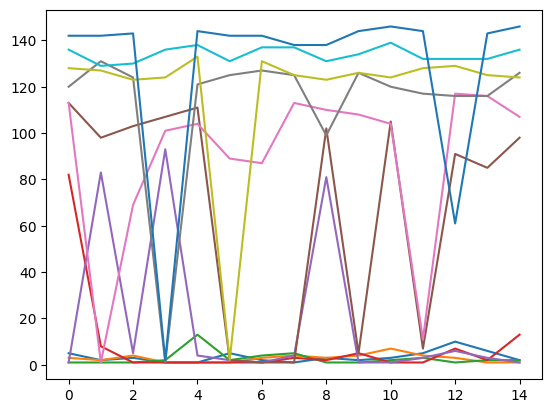

In [120]:
ms_rp = []
ms_rpl = []
for m in ms:
    print(m)
    # plt.plot(dict_r[m,'rp'])
    # ms_rp.append(dict_r[m,'rp'])
    ms_rp.append(dict_r[m,'rp'])
    plt.plot(dict_r[m,'NP'])
    ms_rpl.append(dict_r[m,'rpl'])
mean_rp = np.mean(ms_rp,axis=1)
max_rp = np.max(ms_rp,axis=1)
min_rp = np.min(ms_rp,axis=1)
std_rp = np.std(ms_rp,axis=1)


mean_rpl = np.mean(ms_rpl,axis=1)
max_rpl = np.max(ms_rpl,axis=1)
min_rpl = np.min(ms_rpl,axis=1)
std_rpl = np.std(ms_rpl,axis=1)

(0.0, 0.05)

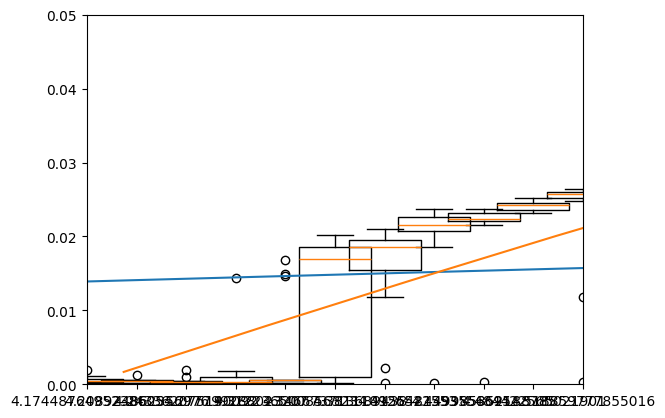

In [127]:
# plt.scatter(ms,mean_rp)
# plt.scatter(ms,max_rp)
# plt.scatter(ms,min_rp)
# plt.boxplot(ms_rp,positions=ms,widths=0.05)
plt.boxplot(ms_rpl,positions=ms,widths=0.05)
plt.plot(ms_,np.abs(RD[:,70])/2)
plt.plot(ms_,np.abs(RP[:,70]))

plt.xlim(ms.min(),ms.max())
plt.ylim(0,0.05)